# ProtoDUNE DP VD PMT Analysis Jupyter Notebook
Authored by Jacob A. Smith.

This notebook serves as the place where all the PMT analysis Python code lives. Note that this notebook is only for single simulation files. Comparing simulation files is done in another notebook.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

%matplotlib inline

In [3]:
# parameters
file_suffix = 'REF40_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_0dot2GeVP0_muons'
#file_suffix = 'REF40_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0_muonNew'
#file_suffix = 'REF40_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0_proton'
#file_suffix = 'REF40_sim_-149X0_-281Y0_479Z0_135Theta0XZ_190Theta0YZ_1GeVP0_muon'

color_axis_max = 10000
plt.rc('axes', axisbelow=True) # plot all grids behind any data points, fits, etc.


In [4]:
# put info from file_suffix into variables for plotting
eng_file_txt = file_suffix[ file_suffix.rfind( '_', 0, file_suffix.find('eVP0')) + 1 : file_suffix.find('eVP0') ]
eng_plot = eng_file_txt.replace('pt', '.')

part_file_txt = file_suffix[ file_suffix.rfind('_') + 1 :]
part_plot = part_file_txt.capitalize()

print(eng_file_txt)
print(eng_plot)
print(part_file_txt)
print(part_plot)

0dot2G
0dot2G
muons
Muons




After conversations with Josè Soto and Clara Cuesta and reading [arXiv 2203.16134](https://arxiv.org/abs/2203.1613), I've come to realize that this efficiency ratio takes into account things like the difference in WLS, loss from WLS to PMT, and PMT quantum efficiency. At the GEANT4/LArG4/truth-level simulation stage, we are not concerned with all of those corrections since the detector is not simulated at this stage. The aforementioned arXiv paper states that PEN foil PMTs receive about 30% more photons due to the fact that PEN PMTs have 2 exposed faces whereas TPB PMTs only have one. This makes the foil_over_coated_eff_ratio for our purposes 1.3. The old value of 1/3 has been kept here, labeled as 'DEPRECIATED', and commented out.

In [5]:
num_pmts = 36; # there are 36 PMTs in the ProtoDUNE DP VD (Optical No-wires) geometry.

# pmts labeled 0 through 35 according to their indices
pmt_labels =  np.array(["PMT 0", "PMT 1", "PMT 2", "PMT 3", "PMT 4", "PMT 5", "PMT 6", "PMT 7", "PMT 8", "PMT 9", "PMT 10", "PMT 11", "PMT 12", "PMT 13", "PMT 14", "PMT 15", "PMT 16", "PMT 17", "PMT 18", "PMT 19", "PMT 20", "PMT 21", "PMT 22", "PMT 23", "PMT 24", "PMT 25", "PMT 26", "PMT 27", "PMT 28", "PMT 29", "PMT 30", "PMT 31", "PMT 32", "PMT 33", "PMT 34", "PMT 35"])
coated_pmts = np.array([2, 10, 15, 21, 26, 34]) # TPB-coated pmts with different efficiency than foil pmts
foil_pmts = np.delete( np.arange( num_pmts), coated_pmts) # PEN foil pmts are every pmt that's not TPB-coated

#foil_over_coated_eff_ratio_DEPRECIATED = 1/3 # relative efficency of PEN foil PMTs over TPB-coated PMTs 
                                              # (https://arxiv.org/pdf/2110.15007.pdf: pg. 3, paragraph 2)
foil_over_coated_eff_ratio = 1.3

# data taken directly from protodunedphase_driftY_optical_nowires.gdml file
# search for "posPMT" to find these values as well as the TPB-coated pmt identification
# units: cm

pmt_xpos = np.array([238, 238, 238, 238, 170, 170, 170, 170, 102, 102, 102, 102, 34, 34, 34, 34, 34, 34, -34, -34, -34, -34, -34, -34, -102, -102, -102, -102, -170, -170, -170, -170, -238, -238, -238, -238])
pmt_zpos = np.array([170, 34, -34, -170, 102, -34, -102, -238, 170, 34, -34, -170, 238, 102, 34, -34, -102, -238, 238, 102, 34, -34, -102, -238, 170, 34, -34, -170, 102, -34, -102, -238, 170, 34, -34, -170])

# zpos raw data from gdml file not accurate; needs +300 cm shift
pmt_zpos += 300

# print out a PMT positions of interest
which_pmts = np.array(range(0,36));
#which_pmts = np.array( [8, 13, 14, 19, 20, 21, 27, 30, 31, 33, 34, 35] );

for pmt_num in which_pmts:
    print(pmt_labels[pmt_num], 'position in xz-plane is (', pmt_xpos[pmt_num], ',', pmt_zpos[pmt_num], ').')

PMT 0 position in xz-plane is ( 238 , 470 ).
PMT 1 position in xz-plane is ( 238 , 334 ).
PMT 2 position in xz-plane is ( 238 , 266 ).
PMT 3 position in xz-plane is ( 238 , 130 ).
PMT 4 position in xz-plane is ( 170 , 402 ).
PMT 5 position in xz-plane is ( 170 , 266 ).
PMT 6 position in xz-plane is ( 170 , 198 ).
PMT 7 position in xz-plane is ( 170 , 62 ).
PMT 8 position in xz-plane is ( 102 , 470 ).
PMT 9 position in xz-plane is ( 102 , 334 ).
PMT 10 position in xz-plane is ( 102 , 266 ).
PMT 11 position in xz-plane is ( 102 , 130 ).
PMT 12 position in xz-plane is ( 34 , 538 ).
PMT 13 position in xz-plane is ( 34 , 402 ).
PMT 14 position in xz-plane is ( 34 , 334 ).
PMT 15 position in xz-plane is ( 34 , 266 ).
PMT 16 position in xz-plane is ( 34 , 198 ).
PMT 17 position in xz-plane is ( 34 , 62 ).
PMT 18 position in xz-plane is ( -34 , 538 ).
PMT 19 position in xz-plane is ( -34 , 402 ).
PMT 20 position in xz-plane is ( -34 , 334 ).
PMT 21 position in xz-plane is ( -34 , 266 ).
PMT 22

In [6]:
# initialize the array for the mean photon counts in each of the PMTs to be -1 values
pmt_mean_phot_count = np.full( num_pmts, -1.)
pmt_mode = np.full( num_pmts, -1.)

# extract the PMT photon count data
f_in = 'pDUNE_DP_VD_optical_nowires_'+file_suffix+'_PMT_data.csv'
#This csv file recorded the photon nums of each pmt!!!---

df_in = pd.read_csv( f_in)

headers = df_in.columns
pmt_number = df_in.values[:,0]
pmt_mean_phot_count = df_in.values[:,1]
pmt_mode = df_in.values[:,2]
    
print(f"Column names: {[ h for h in headers]}")
print(f"Maximum of pmt_mean_phot_count: {max( pmt_mean_phot_count)}")
print(f"Maximum of pmt_mode: {max( pmt_mode)}")

Column names: ['pmt#', 'mean_phot_count', 'mode']
Maximum of pmt_mean_phot_count: 625.958
Maximum of pmt_mode: 589.583


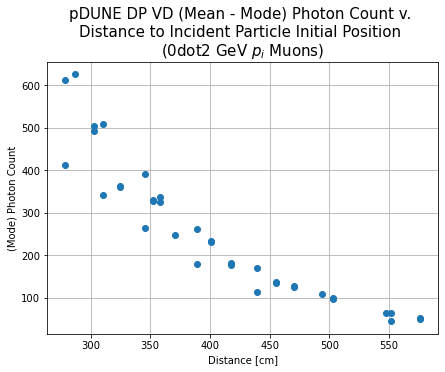

In [7]:
# extract incident particle's initial position from file_suffix variable---
x0 = float(file_suffix[ file_suffix.rfind( '_', 0, file_suffix.find('X0')) + 1 : file_suffix.find('X0') ])
y0 = float(file_suffix[ file_suffix.rfind( '_', 0, file_suffix.find('Y0')) + 1 : file_suffix.find('Y0') ])
z0 = float(file_suffix[ file_suffix.rfind( '_', 0, file_suffix.find('Z0')) + 1 : file_suffix.find('Z0') ])
#In above, x0, y0 and z0 are also array---

#x0 = -149.6
#y0 = -281.7
#z0 = 479.8

# calculate PMT distance to initial position of incident particle---
pmt_dist_to_init_pos = np.sqrt( np.power( pmt_xpos - x0, 2) + np.power( -376.5 - y0, 2) + np.power( pmt_zpos - z0, 2))

#My (Shuaixiang) suggestion:
#pmt_dist_to_init_pos = np.sqrt(np.power(-376.5 - y0, 2) + np.power(pmt_zpos - z0, 2))

#calculate the difference between the mode and mean to see how similar the values are
mean_minus_mode = pmt_mean_phot_count - pmt_mode

# plot the data
plt.figure( figsize=(7, 5))

plt.scatter( pmt_dist_to_init_pos, pmt_mean_phot_count)

plt.xlabel("Distance [cm]")
plt.ylabel("(Mode) Photon Count")
plt.title(f"pDUNE DP VD (Mean - Mode) Photon Count v. \nDistance to Incident Particle Initial Position \n({eng_plot[:-1]} {eng_plot[-1:]}eV $p_i$ {part_plot})", fontsize=15)
plt.grid() # give the plot a grid for viewing

#plt.savefig("pDUNE_DP_VD_"+file_suffix+"mean_minus_mode_versus_dist_to_part_init_pos.jpeg")
plt.show()

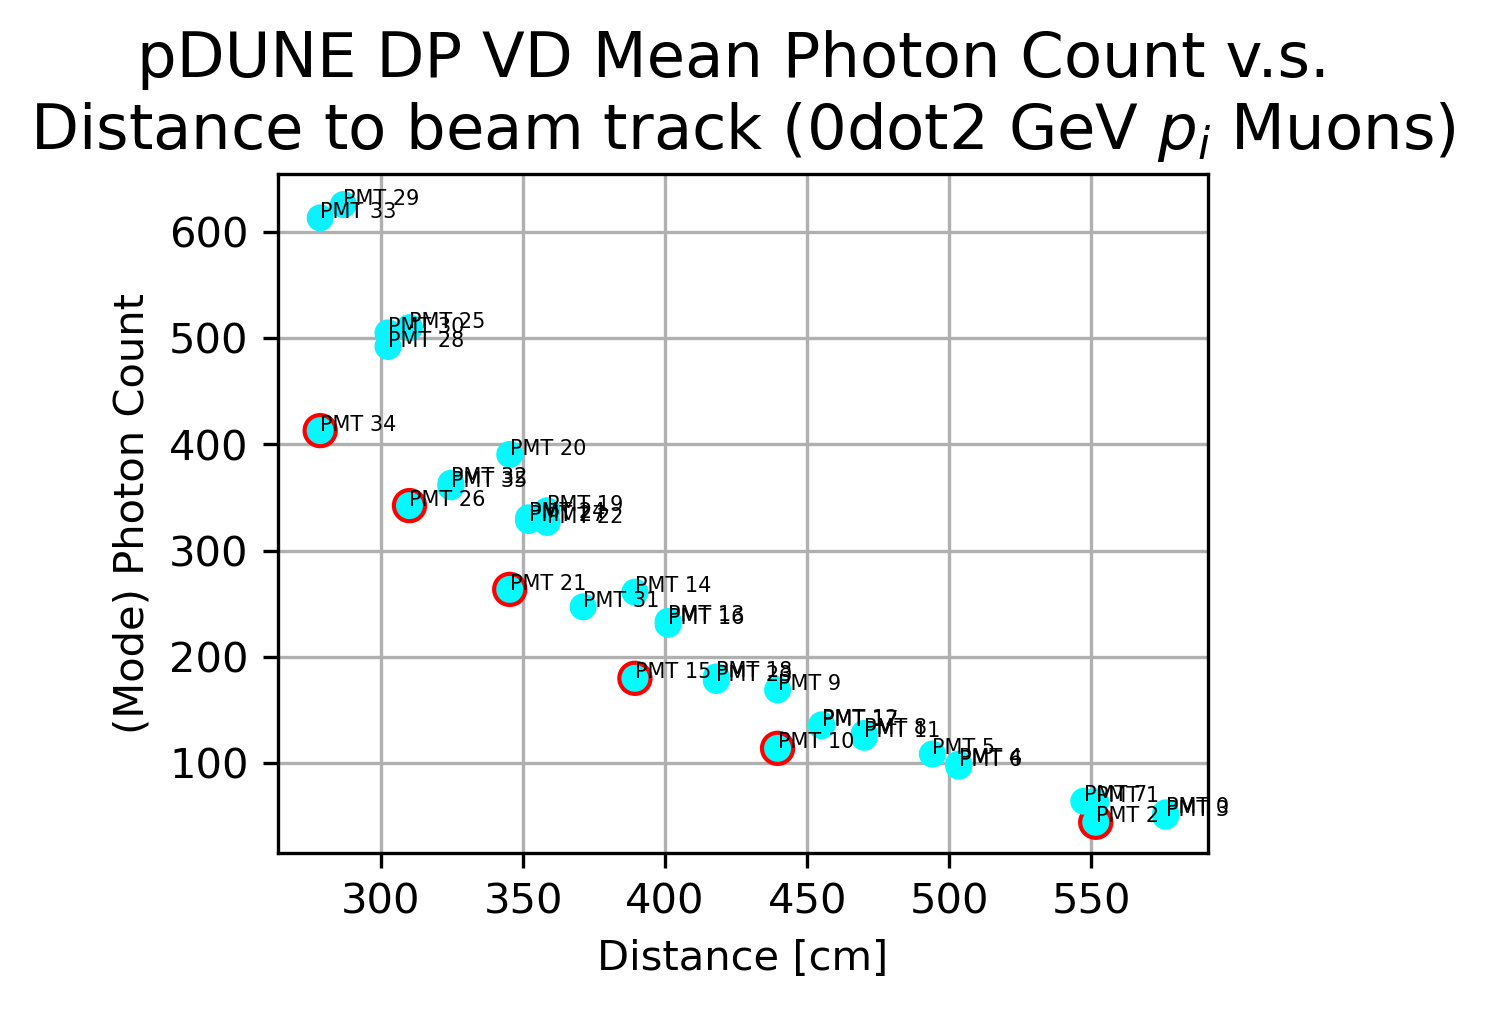

In [8]:
plt.figure(dpi=300,figsize=(4,3))

# extract incident particle's initial position from file_suffix variable---
x0 = float(file_suffix[ file_suffix.rfind( '_', 0, file_suffix.find('X0')) + 1 : file_suffix.find('X0') ])
y0 = float(file_suffix[ file_suffix.rfind( '_', 0, file_suffix.find('Y0')) + 1 : file_suffix.find('Y0') ])
z0 = float(file_suffix[ file_suffix.rfind( '_', 0, file_suffix.find('Z0')) + 1 : file_suffix.find('Z0') ])

#My (Shuaixiang) suggestion:---
#pmt_dist_to_init_pos = np.sqrt(np.power(-376.5 - y0, 2) + np.power(pmt_zpos - z0, 2))

# start with the TPB-coated PMTs outline---
plt.scatter( pmt_dist_to_init_pos[coated_pmts], pmt_mean_phot_count[coated_pmts], 
            s=30,
            color="None", 
            edgecolors='red',
            linewidth=3)

# plot the color-coded and size-coded data
plt.scatter( pmt_dist_to_init_pos, pmt_mean_phot_count, 
#            s=pmt_mean_phot_count, 
            vmin=1, vmax=color_axis_max, s=30,#s is size---
            c=pmt_mean_phot_count,#c is color--- 
            cmap='cool')

plt.xlabel("Distance [cm]")
plt.ylabel("(Mode) Photon Count")
plt.title(f"pDUNE DP VD Mean Photon Count v.s. \nDistance to beam track ({eng_plot[:-1]} {eng_plot[-1:]}eV $p_i$ {part_plot})", fontsize=15)
plt.grid()



# label each of the PMTs with plain text---
for i, label in enumerate(pmt_labels):
     plt.annotate(label, 
                  (pmt_dist_to_init_pos[i], pmt_mean_phot_count[i]),
                  fontsize=5) # shift in position centers labels above points


### Plot PMT Positions with MEAN photon count data and TPB-coated PMTs labeled in orange.

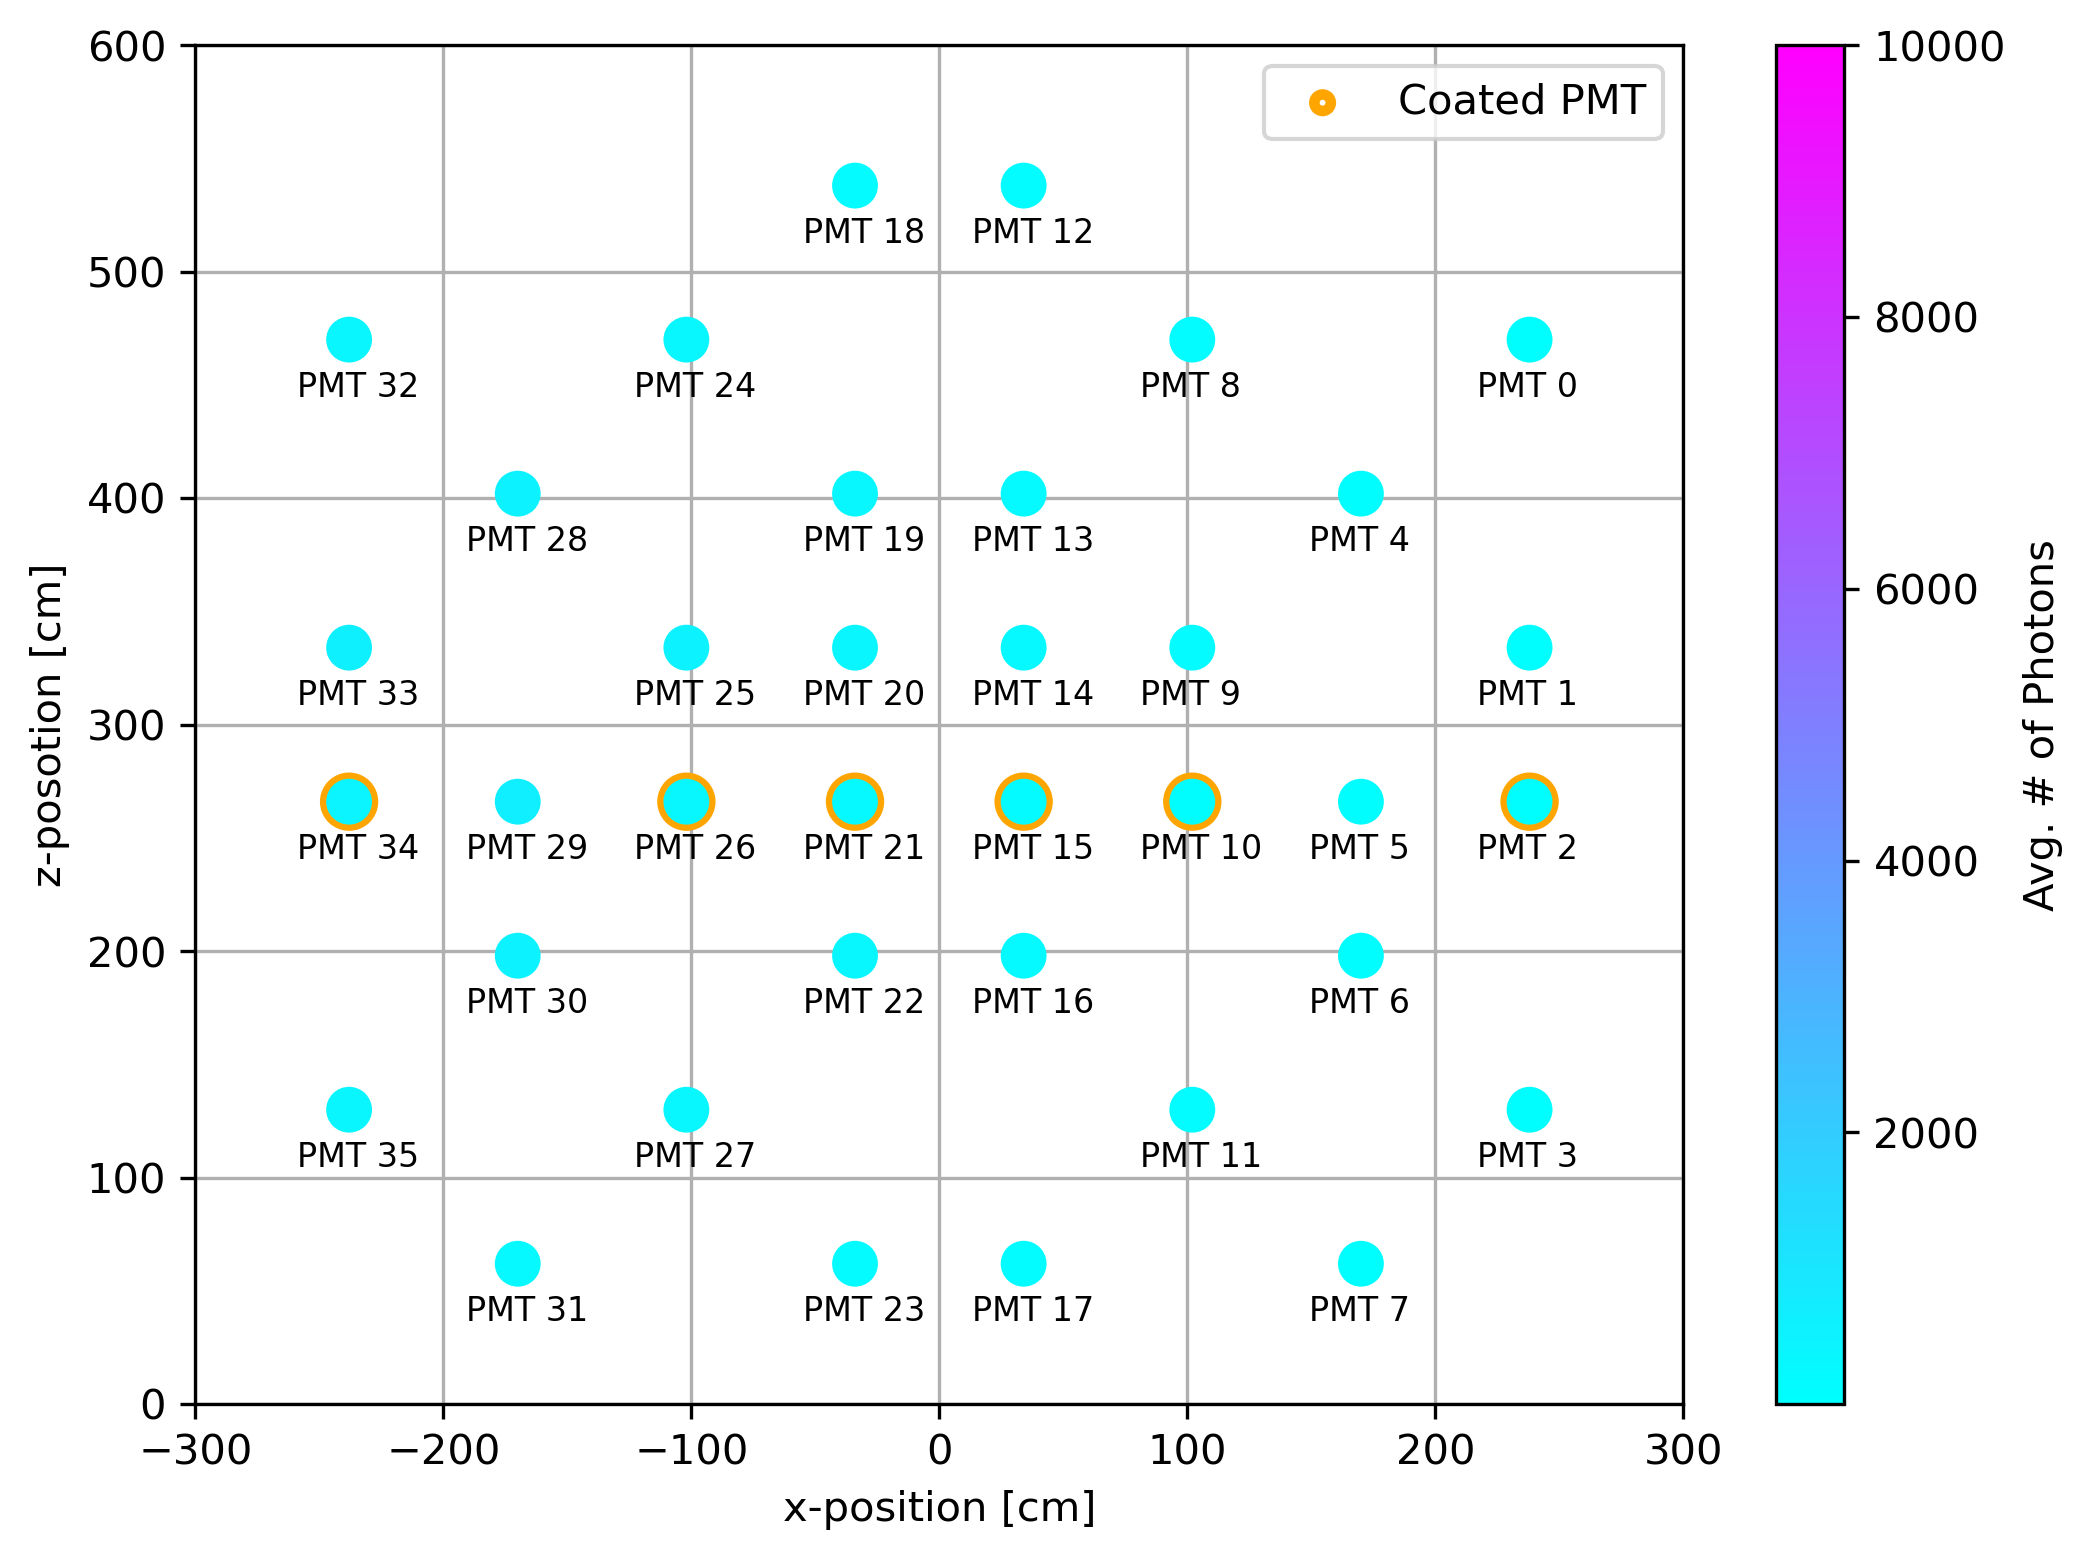

PMT 0 count is:  52.862
PMT 1 count is:  63.172
PMT 2 count is:  43.93
PMT 3 count is:  49.622
PMT 4 count is:  98.744
PMT 5 count is:  108.204
PMT 6 count is:  96.74
PMT 7 count is:  63.8
PMT 8 count is:  127.624
PMT 9 count is:  168.684
PMT 10 count is:  113.6
PMT 11 count is:  123.974
PMT 12 count is:  135.768
PMT 13 count is:  233.274
PMT 14 count is:  260.808
PMT 15 count is:  179.592
PMT 16 count is:  230.512
PMT 17 count is:  134.912
PMT 18 count is:  180.908
PMT 19 count is:  337.464
PMT 20 count is:  390.53
PMT 21 count is:  263.354
PMT 22 count is:  326.442
PMT 23 count is:  177.512
PMT 24 count is:  330.804
PMT 25 count is:  510.01
PMT 26 count is:  342.298
PMT 27 count is:  328.252
PMT 28 count is:  492.214
PMT 29 count is:  625.958
PMT 30 count is:  505.068
PMT 31 count is:  246.914
PMT 32 count is:  363.332
PMT 33 count is:  613.39
PMT 34 count is:  412.95
PMT 35 count is:  360.018


In [13]:
plt.figure(dpi=300, figsize=(8, 6))

# start with the TPB-coated PMTs outline
plt.scatter( pmt_xpos[coated_pmts], pmt_zpos[coated_pmts], 
#            s=pmt_mean_phot_count[coated_pmts], 
            s=100,
            color="None", 
            edgecolors='orange',
            linewidth=4)

# create a legend just for the outline
plt.legend(['Coated PMT'], markerscale=0.25)

# plot the color-coded and size-coded data
plt.scatter( pmt_xpos, pmt_zpos, 
#            s=pmt_mean_phot_count, 
            vmin=1, vmax=color_axis_max, s=100,#s is size---
            c=pmt_mean_phot_count,#c is color--- 
            cmap='cool')

# make the plot look pretty
cbar = plt.colorbar() # add color axis to the right of the plot
cbar.set_label("Avg. # of Photons")
plt.xlabel("x-position [cm]")
plt.ylabel("z-posotion [cm]")
#plt.title(f"ProtoDUNE DP VD PMT Mean Photon Counts ({eng_plot[:-1]} {eng_plot[-1:]}eV $p_i$ {part_plot})", fontsize=15)
plt.xlim(-300, 300)
plt.ylim( 0, 600)
plt.grid()

# label each of the PMTs with plain text
for i, label in enumerate(pmt_labels):
     plt.annotate(label, 
                  (pmt_xpos[i]-21, pmt_zpos[i]-25),
                  fontsize=8) # shift in position centers labels above points

# save the figure
#plt.savefig("pDUNE_DP_VD_"+file_suffix+"PMT_mean_phot_counts_vmaxEq"+str(color_axis_max)+".jpeg")
plt.show()

#Output of photons counts in PMT:
for (pmt, count) in zip(pmt_labels, pmt_mean_phot_count):
    print(pmt, 'count is: ', count)


### Plot PMT positions with MODE photon count data and TPB-coated PMTs labeled in purple.

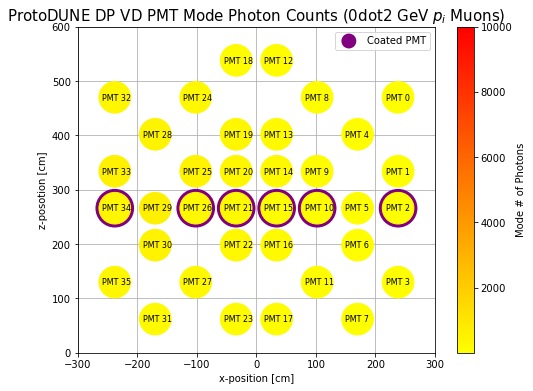

In [9]:
plt.figure( figsize=(8, 6))

# start with the TPB-coated PMTs outline
plt.scatter( pmt_xpos[coated_pmts], pmt_zpos[coated_pmts], 
#            s=pmt_mean_phot_count[coated_pmts], 
            s=1000,
            color="None", 
            edgecolors='purple',
            linewidth=7)

# create a legend just for the outline
plt.legend(['Coated PMT'], markerscale=0.25)

# plot the color-coded and size-coded data
plt.scatter( pmt_xpos, pmt_zpos, 
#            s=pmt_mean_phot_count, 
            vmin=1, vmax=color_axis_max, s=1000,
            c=pmt_mode, 
            cmap='autumn_r') # '_r' reverses the colormap

# make the plot look pretty
cbar = plt.colorbar() # add color axis to the right of the plot
cbar.set_label("Mode # of Photons")
plt.xlabel("x-position [cm]")
plt.ylabel("z-posotion [cm]")
plt.title(f"ProtoDUNE DP VD PMT Mode Photon Counts ({eng_plot[:-1]} {eng_plot[-1:]}eV $p_i$ {part_plot})", fontsize=15)
plt.xlim(-300, 300)
plt.ylim( 0, 600)
plt.grid()

# label each of the PMTs with plain text
for i, label in enumerate(pmt_labels):
     plt.annotate(label, 
                  (pmt_xpos[i]-21, pmt_zpos[i]-5),
                  fontsize=8) # shift in position centers labels above points

# save the figure
#plt.savefig("pDUNE_DP_VD_"+file_suffix+"PMT_mode_phot_counts_vmaxEq"+str(color_axis_max)+".jpeg")
plt.show()


### PMT Photon Count v. PMT Distance to Incident Particle Initial Position

Create a sorted list of PMTs that are closest to the starting position of the incident particle and include PMT photon count information in that list. Then plot the photon count as a function of PMT distance to the incident particle's starting position and fit that data with an exponential function.

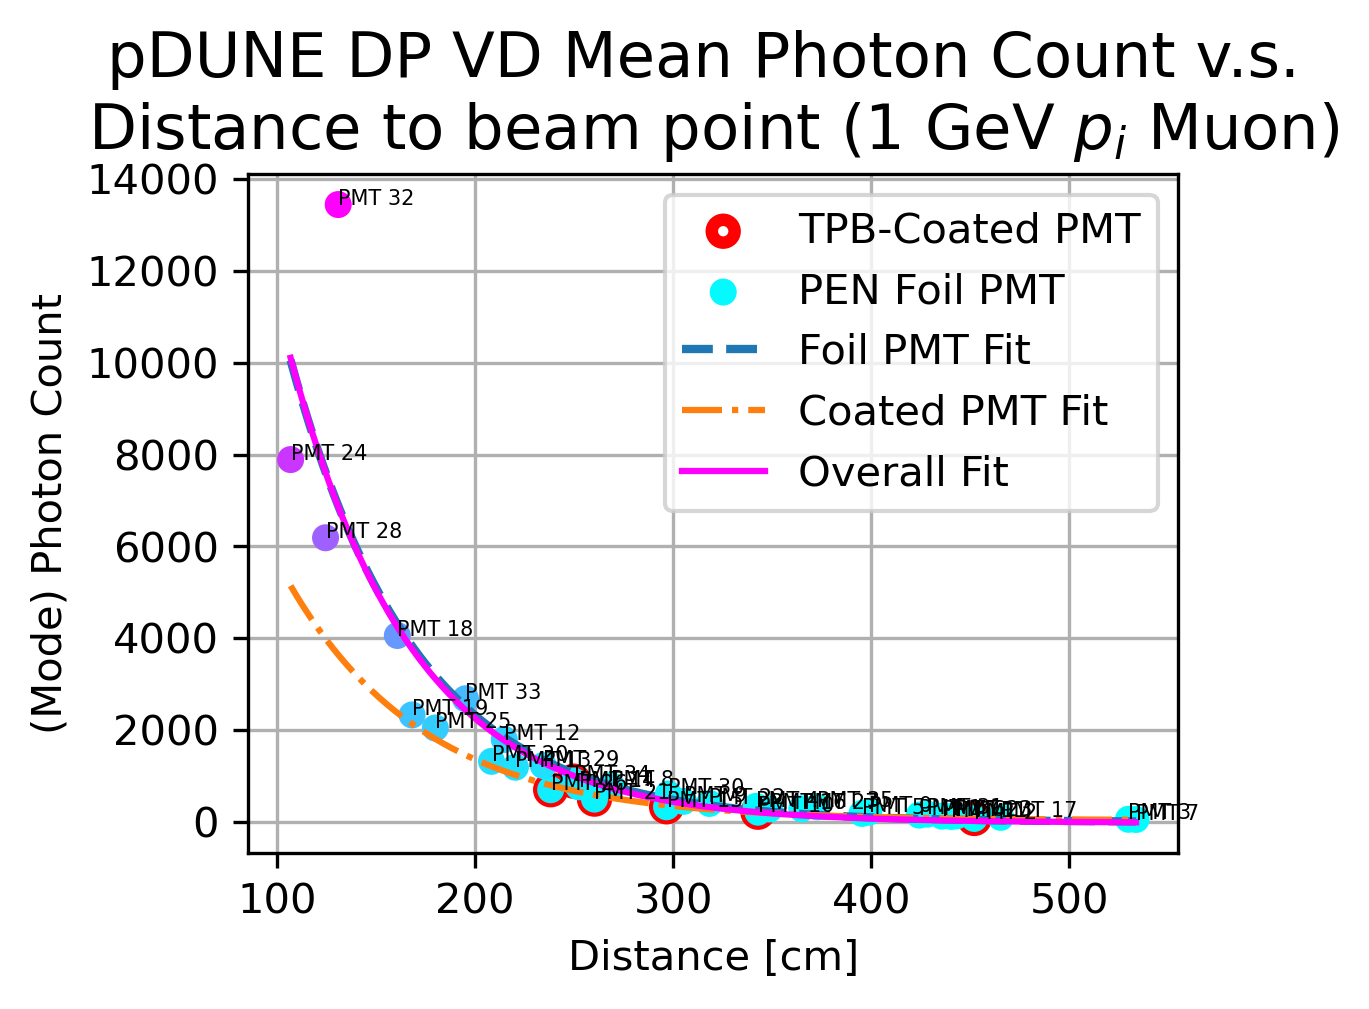

In [22]:
# fit functions for data---
def expo_fit_func(x, p0, r, b):
    return p0 * np.exp(r * x) + b

# fit the data (whole set, PEN foil PMTs, and TPB-coated PMTs) with curve_fit()
popt, pcov = curve_fit(expo_fit_func, pmt_dist_to_init_pos, pmt_mean_phot_count, 
                      p0=(5700, -1/100, 100),
                      maxfev=1000000)
popt_coated, pcov_coated = curve_fit(expo_fit_func, pmt_dist_to_init_pos[coated_pmts], pmt_mean_phot_count[coated_pmts],
                      p0=(5700, -1/100, 100),
                      maxfev=100000)
popt_foil, pcov_foil = curve_fit(expo_fit_func, pmt_dist_to_init_pos[foil_pmts], pmt_mean_phot_count[foil_pmts],
                      p0=(5700, -1/100, 100),
                      maxfev=100000)

# plot the data---
plt.figure(dpi=300,figsize=(4,3))
# start with the TPB-coated PMTs outline---
plt.scatter( pmt_dist_to_init_pos[coated_pmts], pmt_mean_phot_count[coated_pmts], 
            s=30,
            color="None", 
            edgecolors='red',
            linewidth=3)
# plot the color-coded and size-coded data
plt.scatter( pmt_dist_to_init_pos, pmt_mean_phot_count, 
#            s=pmt_mean_phot_count, 
            vmin=1, vmax=color_axis_max, s=30,#s is size---
            c=pmt_mean_phot_count,#c is color--- 
            cmap='cool')
#Set the labels--
plt.xlabel("Distance [cm]")
plt.ylabel("(Mode) Photon Count")
plt.title(f"pDUNE DP VD Mean Photon Count v.s. \nDistance to beam point ({eng_plot[:-1]} {eng_plot[-1:]}eV $p_i$ {part_plot})", fontsize=15)
plt.grid()

#Fitting---
plot_xrange = np.linspace( min(pmt_dist_to_init_pos), max(pmt_dist_to_init_pos), 10000)
plt.plot(plot_xrange, expo_fit_func(plot_xrange, *popt_foil), '--', linewidth=2)
plt.plot(plot_xrange, expo_fit_func(plot_xrange, *popt_coated), '-.')
plt.plot(plot_xrange, expo_fit_func(plot_xrange, *popt), color='magenta')
plt.legend( ['TPB-Coated PMT' ,'PEN Foil PMT', 'Foil PMT Fit', 'Coated PMT Fit', 'Overall Fit'])


# label each of the PMTs with plain text---
for i, label in enumerate(pmt_labels):
     plt.annotate(label, 
                  (pmt_dist_to_init_pos[i], pmt_mean_phot_count[i]),
                  fontsize=5) # shift in position centers labels above points



[398.71073474 424.16299933 451.94938876 529.80208569 341.77514538
 395.28502375 435.70890512 533.63868863 268.70476363 305.19870576
 342.76850789 440.36604093 214.6863992  220.31398049 252.25830016
 296.6112776  348.66925589 465.29372444 160.70547595 168.14948706
 208.25525203 260.21961878 318.28642761 442.98335183 106.81877176
 179.87287177 238.11394331 364.87018239 124.45983288 234.37203331
 297.52688954 428.31092678 130.85201565 195.10574056 249.82043551
 372.61541836]
[   54.844    58.381    77.035   101.29    120.996   127.36    132.411
   149.907   170.542   186.758   213.08    215.217   282.85    286.398
   328.299   331.152   339.409   404.144   448.557   498.161   609.439
   702.403   766.541   794.221   889.042  1192.73   1229.04   1320.92
  1796.7    2046.72   2331.07   2683.72   4061.56   6189.89   7892.78
 13446.7  ]


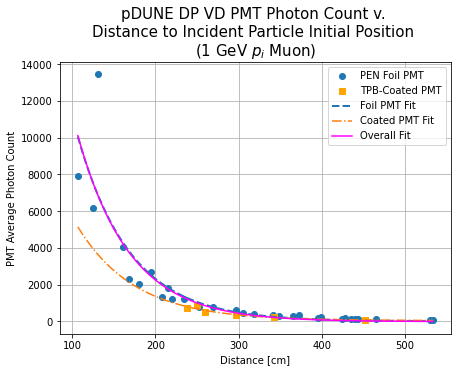

popt: [ 5.62226832e+04 -1.60477937e-02 -1.72859409e+01]
popt_foil: [ 5.40282912e+04 -1.57403010e-02 -7.85064355e-02]
popt_coated: [ 2.40122435e+04 -1.44909566e-02  3.74809844e+01]


In [23]:
# fit functions for data
def expo_fit_func(x, p0, r, b):
    return p0 * np.exp(r * x) + b

# fit the data (whole set, PEN foil PMTs, and TPB-coated PMTs) with curve_fit()
popt, pcov = curve_fit(expo_fit_func, pmt_dist_to_init_pos, pmt_mean_phot_count, 
                      p0=(5700, -1/100, 100),
                      maxfev=1000000)
popt_coated, pcov_coated = curve_fit(expo_fit_func, pmt_dist_to_init_pos[coated_pmts], pmt_mean_phot_count[coated_pmts],
                      p0=(5700, -1/100, 100),
                      maxfev=100000)
popt_foil, pcov_foil = curve_fit(expo_fit_func, pmt_dist_to_init_pos[foil_pmts], pmt_mean_phot_count[foil_pmts],
                      p0=(5700, -1/100, 100),
                      maxfev=100000)

# plot the data
plt.figure( figsize=(7, 5))
print(pmt_dist_to_init_pos)
print(np.sort(pmt_mean_phot_count))
plt.scatter( pmt_dist_to_init_pos, pmt_mean_phot_count) 
plt.scatter( pmt_dist_to_init_pos[coated_pmts], pmt_mean_phot_count[coated_pmts],
           color='orange', marker='s') # give the TPB-coated pmts a different color and shape

plot_xrange = np.linspace( min(pmt_dist_to_init_pos), max(pmt_dist_to_init_pos), 10000)
plt.plot(plot_xrange, expo_fit_func(plot_xrange, *popt_foil), '--', linewidth=2)
plt.plot(plot_xrange, expo_fit_func(plot_xrange, *popt_coated), '-.')
plt.plot(plot_xrange, expo_fit_func(plot_xrange, *popt), color='magenta')

plt.legend(['PEN Foil PMT', 'TPB-Coated PMT', 'Foil PMT Fit', 'Coated PMT Fit', 'Overall Fit'])
        
plt.xlabel("Distance [cm]")
plt.ylabel("PMT Average Photon Count")
plt.title(f"pDUNE DP VD PMT Photon Count v. \nDistance to Incident Particle Initial Position \n({eng_plot[:-1]} {eng_plot[-1:]}eV $p_i$ {part_plot})", fontsize=15)
plt.grid() # give the plot a grid for viewing

#plt.savefig("pDUNE_DP_VD_"+file_suffix+"PMT_mean_phot_count_versus_dist_to_part_init_pos.jpeg")
plt.show()

print(f"popt: {popt}")
print(f"popt_foil: {popt_foil}")
print(f"popt_coated: {popt_coated}")

### Efficiency Calculations (Ratio of PEN Foil PMT Count to TPB-Coated PMT Count)

**The formulas are:**
    $$
    R=\frac{N_n}{N_d}\\\delta R=\frac1{N_d^2}\sqrt{N_d^2\left(\delta N_n\right)^2+N_n^2\left(\delta N_d\right)^2}
    $$

In [43]:
# gather the data
numerator_pmts   = np.array([33, 25, 20, 14, 9,  1])
denominator_pmts = np.array([34, 26, 21, 15, 10, 2])

num_mean_vals    = pmt_mean_phot_count[ numerator_pmts]
num_mode_vals    = pmt_mode[ numerator_pmts]
denom_mean_vals  = pmt_mean_phot_count[ denominator_pmts]
denom_mode_vals  = pmt_mode[ denominator_pmts]

err_mean_num     = np.sqrt( num_mean_vals)
err_mode_num     = np.sqrt( num_mode_vals)
err_mean_denom   = np.sqrt( denom_mean_vals)
err_mode_denom   = np.sqrt( denom_mode_vals)

In [18]:
# calculate ratios and print to the output data frame
mean_phot_count_ratio = num_mean_vals / denom_mean_vals
mode_phot_count_ratio = num_mode_vals / denom_mode_vals

# error propagation is done for the ratio in the standard fashion
# of sqrt(  (df/dx1)^2 \sigma_x1^2 + ...  ) for all variables xi. 

mean_phot_count_ratio_err =np.sqrt((denom_mean_vals)**2*(err_mean_num)**2 
                                   + (num_mean_vals)**2*(err_mean_denom)**2)/((denom_mean_vals)**2)
mode_phot_count_ratio_err =np.sqrt((denom_mode_vals)**2*(err_mode_num)**2 
                                   + (num_mode_vals)**2*(err_mode_denom)**2)/((denom_mode_vals)**2)

# save the efficiency ratio data to a csv file
pmts_in_ratio = np.array([f'{n}/{d}' for n, d in zip( numerator_pmts, denominator_pmts)])

# we have columnar data, but we need to organize it in rows
data_out = np.array( 
    [ [pmt, mean, mean_err, mode, mode_err] for 
     pmt, mean, mean_err, mode, mode_err 
     in zip( pmts_in_ratio, 
            mean_phot_count_ratio, 
            mean_phot_count_ratio_err, 
            mode_phot_count_ratio, 
            mode_phot_count_ratio_err) ])

df_out = pd.DataFrame(data_out, columns = ['pmtX_over_pmtY', 'Ratio(mean)', 'Ratio_err(mean)', 'Ratio(mode)', 'Ratio_err(mode)'])
#df_out.to_csv('PEN_over_TBP_PMT_efficiencies'+file_suffix+'.csv')

print( df_out)

  pmtX_over_pmtY         Ratio(mean)       Ratio_err(mean)  \
0          33/34  1.4974953785506435   0.04670082531990402   
1          25/26  1.5000416225665665  0.038556273586020824   
2          20/21  1.4890759913014968   0.03737505796783067   
3          14/15  1.4965223102305008    0.0384468094239442   
4           9/10  1.5056421254569805   0.04131507468545034   
5            1/2  1.4991766981599604  0.054725006748435064   

          Ratio(mode)       Ratio_err(mode)  
0  1.5116328257191203   0.04722927163743175  
1   1.509388420425692  0.038524526512713535  
2    1.50886724301279   0.03742960588557994  
3  1.4948459887022854  0.037677618691839054  
4  1.5510769618339841   0.04219068119491239  
5  1.4090202898550725  0.051221662590301205  
